In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
Inspector = inspect(engine)
Inspector.get_table_names()
measurement_cols = Inspector.get_columns('measurement')
for column in measurement_cols:
    print(column.values())

dict_values(['id', INTEGER(), False, None, 'auto', 1])
dict_values(['station', TEXT(), True, None, 'auto', 0])
dict_values(['date', TEXT(), True, None, 'auto', 0])
dict_values(['prcp', FLOAT(), True, None, 'auto', 0])
dict_values(['tobs', FLOAT(), True, None, 'auto', 0])


In [11]:
station_cols = Inspector.get_columns('station')
for column in station_cols:
    print(column.values())

dict_values(['id', INTEGER(), False, None, 'auto', 1])
dict_values(['station', TEXT(), True, None, 'auto', 0])
dict_values(['name', TEXT(), True, None, 'auto', 0])
dict_values(['latitude', FLOAT(), True, None, 'auto', 0])
dict_values(['longitude', FLOAT(), True, None, 'auto', 0])
dict_values(['elevation', FLOAT(), True, None, 'auto', 0])


Last date of precipitation data in the databse is 2017-08-23
Now plotting the precipitation in the past 12 months


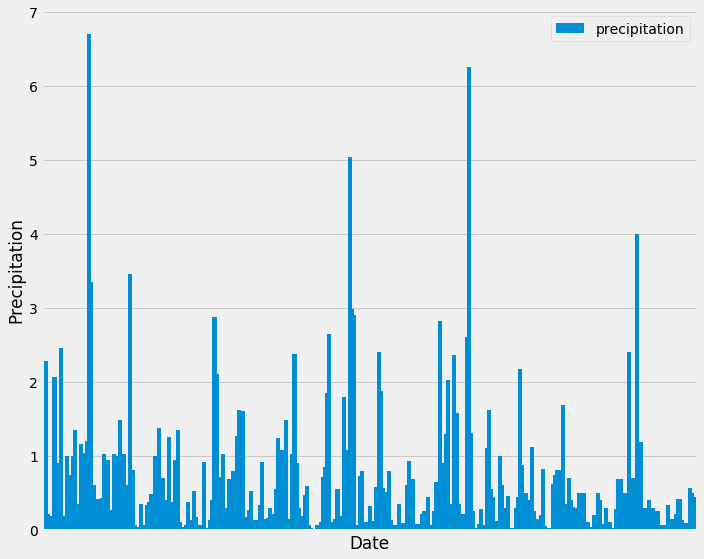

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
lastdate, = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f'Last date of precipitation data in the databse is {lastdate}')
print(f'Now plotting the precipitation in the past 12 months')

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, func.max(Measurement.prcp))\
                   .filter(Measurement.date >= '2016-08-23')\
                   .group_by(Measurement.date)\
                   .order_by(Measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
dates = list()
precipitation = list()
for each in prcp_data:
    
    if each[1] == None or each[1] == 0.00:
        pass
    else:
        dates.append(each[0])
        precipitation.append(each[1])
        
prcp_df = pd.DataFrame({
    'date' : dates,
    'precipitation' : precipitation,
})

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(kind='bar', width=2, figsize=(10,8))
plt.xticks([])
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

![precipitation](Images/precipitation.png)

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
summary = pd.DataFrame(index={'2016-08 to date'},
                       data={'prcp_mean': [round(prcp_df.mean()['precipitation'],2)],
                             'prcp_max': prcp_df.max()['precipitation'],
                             'prcp_sum': prcp_df.sum()['precipitation']})
summary

,prcp_mean,prcp_max,prcp_sum
2016-08 to date,0.6,6.7,190.6


![describe](Images/describe.png)

In [14]:
# Design a query to show how many stations are available in this dataset?
num_of_stations = session.query(Station.station).count()
num_of_stations

9

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
activate_stations = session.query(Measurement.station, func.count(Measurement.id))\
                           .group_by(Measurement.station)\
                           .order_by(func.count(Measurement.id).desc())\
                           .all()                           
for each in activate_stations:
    print(each[0], each[1])

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
tobs = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs), func.avg(Measurement.tobs))\
              .filter(Measurement.station == 'USC00519281').first()
tmin = tobs[0]
tmax = tobs[1]
tavg = tobs[2]
print(f"Lowest temperature is {tmin}\nHighest temperature is {tmax}\nAverage temperature is {tavg}")

Lowest temperature is 54.0
Highest temperature is 85.0
Average temperature is 71.66378066378067


Last date of temperature measurement for station "USC00519281" is 2017-08-18.
Now plotting the histogram for temperature in the past 12 months:


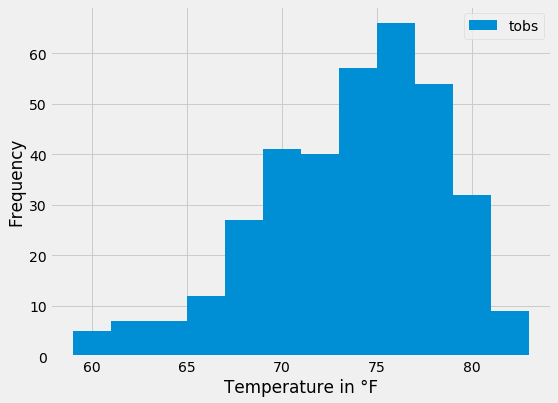

In [17]:
# Choose the station with the highest number of temperature observations.
# Finding the last date of measurement for the most activate station: USC00519281.
last_date_tob, = session.query(Measurement.date)\
                   .filter(Measurement.station == 'USC00519281')\
                   .order_by(Measurement.date.desc()).first()
print(f'Last date of temperature measurement for station "USC00519281" is {last_date_tob}.')
print(f'Now plotting the histogram for temperature in the past 12 months:')
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tob_query = session.query(Measurement.date, Measurement.tobs)\
                   .filter(Measurement.station == 'USC00519281')\
                   .filter(Measurement.date >= '2016-08-18').all()
tobs = list()
for each in tob_query:
    tobs.append(each[1])
plt.figure(figsize=(8,6))
plt.hist(tobs, bins=12, label='tobs')
plt.legend()
plt.xlabel('Temperature in °F')
plt.ylabel('Frequency')
plt.show()

![precipitation](Images/station-histogram.png)

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


# Temperature Analysis I

In [19]:
# Calculate the temperature in June and December at all stations across all years.
june_temp, = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '06').first()
dec_temp, = session.query(func.avg(Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '12').first()
print(f'Average temperature in June is {round(june_temp,2)} °F')
print(f'Average temperature in December is {round(dec_temp,2)} °F')

Average temperature in June is 74.94 °F
Average temperature in December is 71.04 °F


In [20]:
# t-test
import scipy.stats as sts
june_population = session.query((Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '06').all()
dec_population = session.query((Measurement.tobs)).filter(func.strftime("%m", Measurement.date) == '12').all()
june_population = list(np.ravel(june_population))
dec_population = list(np.ravel(dec_population))

sts.ttest_ind(june_population, dec_population)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
(startdate, enddate) = ('2016-03-05', '2016-03-12')
temp_query = calc_temps(startdate, enddate)
(TMIN, TAVG, TMAX) = list(np.ravel(temp_query))
(TMIN,TAVG,TMAX)

(63.0, 70.6923076923077, 78.0)

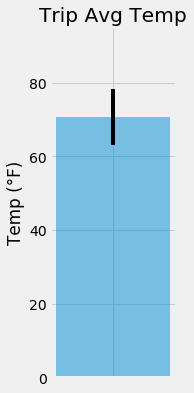

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2,6))
plt.bar(1, height=TAVG, yerr=(TMAX-TMIN)/2, alpha=0.5, tick_label='')
plt.title('Trip Avg Temp')
plt.ylabel('Temp (°F)')
plt.ylim(0,95)
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rainfall = session.query(Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation)\
                  .filter(Measurement.station == Station.station)\
                  .filter(Measurement.date >= startdate).filter(Measurement.date <= enddate)\
                  .group_by(Measurement.station)\
                  .order_by(func.sum(Measurement.prcp).desc()).all()
station_list = []
name_list = []
lats = []
lngs = []
elevations = []
for station, name, lat, lng, elevation in rainfall:
    station_list.append(station)
    name_list.append(name)
    lats.append(lat)
    lngs.append(lng)
    elevations.append(elevation)
rainfall_df = pd.DataFrame({
    'Station':station_list,
    'Name': name_list,
    'Latitude': lats,
    'Longitude': lngs,
    'Elevation': elevations
})
rainfall_df

,Station,Name,Latitude,Longitude,Elevation
0,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9


## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

In [25]:
# calculate the daily normals for your trip
# (startdate, enddate) = ('2016-03-05', '2016-03-12')
query_dates = []
dates = []
for i in range(8):
    query_date = dt.date(2016, 3, 5) + dt.timedelta(days=i)
    query_dates.append(query_date)
    dates.append(query_date.strftime("%m-%d"))

In [26]:
tmin = list()
tavg = list()
tmax = list()

for i in range(8):
    data = daily_normals(dates[i])
    tmin.append(data[0][0])
    tavg.append(data[0][1])
    tmax.append(data[0][2])

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame({
    'date': query_dates,
    'tmin': tmin,
    'tavg': tavg,
    'tmax': tmax
})
df = df.set_index('date')

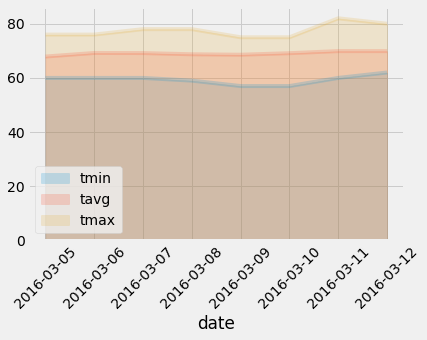

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', alpha=0.2, stacked=False, rot=45)